In [1]:
import tensorflow as tf
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

import gym
from gym import spaces
from gym.utils import seeding

import numpy as np
from ads_utils import load_data, plot

In [2]:
print(tf.__version__)

'''Requires this version of tensorflow. I may checkout stable_baselines3 
(as it seems to integrate with pytorch instead)'''

1.15.0


'Requires this version of tensorflow. I may checkout stable_baselines3 \n(as it seems to integrate with pytorch instead)'

Using stable_baselines with our data. May need a lot of refactoring.

#### LIST OF METHODS
__init__:
- action_space 
- observation_space

step:
- returns observation, reward, done, info
- observation: 

reset:
- "reset" everything in the environment, eg. balance = INITIAL_BALANCE
- returns the next observation_space


https://github.com/notadamking/Stock-Trading-Environment/blob/master/env/StockTradingEnv.py
The code follows some of this implementation. 


In [123]:
INITIAL_BALANCE = 1_000_000

class Environment(gym.Env):  
    # required for stable baselines 
    metadata = {'render.modes': ['human']}
    
    SELL, HOLD, BUY = 0, 1, 2
    PRICES, POSITION, BALANCE = 0, 1, 2
    
    def __init__(self, data, balance, transaction_cost=0.001, i=0, position=1, past_days=5):
        self.past_days = past_days
        self.current_step = self.past_days
        self.initial_balance = self.balance = balance
        
        self.done = False
        self.data = data
        self.position = position
        self.transaction_cost = transaction_cost
        
        self._seed()
        
        # Sell, Hold, Buy == 0, 1, 2 
        self.action_space = spaces.Discrete(3)

        '''
        What do you want the agent to observe?
        - closing prices of the last x=past_days days
        - current timestep's closing price
        - current balance 
        - current portfolio value
        - current position
        TOTAL: shape = (past_days + 4, )
        * the values are in [0, inf]'''
        # Observation space has past_days prices up to and included current price, then balance, portfolio value and position
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (self.past_days+4, ))
        
    def _next_observation(self):        
        '''Getting the next observation'''
        # Hi Grace - delete this when you read it, I added +1 here such that the frame included the current step - Cameron
        frame = np.array(self.data[self.current_step - self.past_days + 1: self.current_step + 1])
        obs = np.append(frame, [self.balance, self.portfolio_value, self.position], axis=0)
        return obs

    def _take_action(self, action):
        curr_price = self.data[self.current_step]
        
        # Perform position transition (transaction cost is a proportion of price)
        self.balance -= curr_price * self.transaction_cost * abs(action - self.position)
        
        # A Buy
        if (action == self.BUY and self.position == self.HOLD) or (action == self.HOLD and self.position == self.SELL):
            self.balance -= curr_price
        
        # A Sell
        elif (action == self.SELL and self.position == self.HOLD) or (action == self.HOLD and self.position == self.BUY):
            self.balance += curr_price
            
        # Flip Position
        elif abs(action - self.position) == 2:
            self.balance -= 2 * (action-1) * curr_price
        
        # Update position
        self.position = action
        
    def step(self, action):
        ''' Updates environment with action taken, returns new state and reward from state transition '''
        
        prior_portfolio_value = self.get_portfolio_value()
        
        # Take action
        self._take_action(action)
        
        # the change in portfolio value
        reward = self.get_portfolio_value() - prior_portfolio_value     
        
        # current portfolio value
        self.portfolio_value = self.get_portfolio_value()
        
        # Update historical data
        self.current_step += 1
        
        # no more money
        if self.balance <= 0:
            self.done = True
            reward = -1e6
        
        obs = self._next_observation()
        
        # required to return: observation, reward, done, info
        return obs, reward, self.done, {}
    
    def get_portfolio_value(self):
        ''' Returns current portfolio value '''
        curr_price = self.data[self.current_step]
        
        if self.position == self.BUY:
            return self.balance + curr_price
        
        elif self.position == self.SELL:
            return self.balance - curr_price
        
        return self.balance
    
    def reset(self):
        '''Reset everything as if we just started (for a new episode)'''
        self.position = self.HOLD
        self.balance = self.initial_balance
        self.net_worth = self.initial_balance
        self.max_net_worth = self.initial_balance
        self.portfolio_value = self.balance
        self.done = False
        self.current_step = self.past_days
        
        # Must return first observation
        return self._next_observation()   

    def save_portfolio(self, mode='human'):
        with open('output.csv', 'a') as file:
            file.write(f'{self.current_step},{self.portfolio_value},{self.balance}\n')
        return
    
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def __repr__(self):
        return f'Balance: ${round(self.balance, 2)}, Price: ${round(self.data[self.current_step], 2)}, ' +\
               f'Position: {self.position}'
            
        
'''NOTE: there is no train/test split yet'''            
data = load_data([2])

fake = np.linspace(100, 200, len(data))
data['close'] = fake

env = Environment(data.close.to_list(), INITIAL_BALANCE)
env

Balance: $1000000, Price: $100.05, Position: 1

In [124]:
env.reset()
env.get_portfolio_value()

1000000

In [125]:
env.step(2)

(array([1.00019431e+02, 1.00029146e+02, 1.00038861e+02, 1.00048577e+02,
        1.00058292e+02, 9.99899851e+05, 9.99999900e+05, 2.00000000e+00]),
 -0.10004857671447098,
 False,
 {})

Balance, Portfolio_value may go to negative, hence this error :(
- TODO: find out how to "restrict" these

In [4]:
from stable_baselines.common.env_checker import check_env

env_check = Environment(data, INITIAL_BALANCE)
# It will check your custom environment and output additional warnings if needed
check_env(env_check)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The model used is PPO2 

#### Short excerpt from docs: 
The Proximal Policy Optimization (PPO) algorithm combines ideas from A2C (having multiple workers) and TRPO (it uses a trust region to improve the actor).

#### Link to doc:
https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html

* there's other actor-critic based models to implement as well


PS: I have yet to know how to interpret the results below

In [86]:
from stable_baselines import PPO2
from stable_baselines.common.policies import MlpPolicy

model = PPO2(MlpPolicy, env, verbose=1)


model.learn(total_timesteps=1000) 

Wrapping the env in a DummyVecEnv.
---------------------------------------
| approxkl           | 0.00013633631  |
| clipfrac           | 0.0            |
| explained_variance | 0              |
| fps                | 260            |
| n_updates          | 1              |
| policy_entropy     | 1.0984442      |
| policy_loss        | -0.00034194475 |
| serial_timesteps   | 128            |
| time_elapsed       | 0              |
| total_timesteps    | 128            |
| value_loss         | 3853.3381      |
---------------------------------------
--------------------------------------
| approxkl           | 0.0003208935  |
| clipfrac           | 0.0           |
| explained_variance | 0             |
| fps                | 844           |
| n_updates          | 2             |
| policy_entropy     | 1.0970773     |
| policy_loss        | -0.0026517473 |
| serial_timesteps   | 256           |
| time_elapsed       | 0.492         |
| total_timesteps    | 256           |
| value_loss    

In [87]:
from tqdm import tqdm

In [95]:
obs = env.reset()
#env = Environment(test_data, INITIAL_BALANCE)

prices = []
rewards = []
actions = []
for i in tqdm(range(10000)):
    action, _states = model.predict(obs)
    
    obs, reward, done, _ = env.step(action)
    
    actions.append(action)
    rewards.append(reward)

    prices.append(obs[5]) # current timestep's closing price
    env.save_portfolio()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:18<00:00, 539.48it/s]


In [89]:
rewards

[0.0,
 -100.15835033520125,
 199.93587875261437,
 0.0,
 0.0,
 -100.19725055864546,
 0.0,
 0.0,
 100.02617312734947,
 -100.23615078208968,
 0.0,
 -100.25560089375358,
 200.12999125616625,
 0.0,
 -200.5695521228481,
 0.0,
 100.10381812881678,
 0.0,
 -100.32367628475185,
 0.0,
 200.28528125910088,
 -100.35285145242233,
 -100.36257650831249,
 100.1717575051589,
 0.0,
 0.0,
 0.0,
 -100.41120178764686,
 100.22028563101776,
 -100.43065189931076,
 200.47939376276918,
 -100.45010201109108,
 0.0,
 100.26881375687663,
 0.0,
 -200.97800446907058,
 100.29793063248508,
 -100.50845234619919,
 200.6346837657038,
 -100.52790245797951,
 -100.53762751375325,
 200.6929175168043,
 0.0,
 0.0,
 -201.15305547462776,
 0.0,
 200.78997376852203,
 0.0,
 0.0,
 -100.62515301664826,
 100.43380938505288,
 -100.64460312831216,
 -100.65432818420231,
 100.46292626054492,
 100.47263188578654,
 -201.36700670351274,
 100.49204313603695,
 -100.70295346353669,
 0.0,
 100.5211600116454,
 100.53086563688703,
 0.0,
 -100.751578

In [96]:
portfolio = pd.read_csv("output.csv", header=None, names=["index", "portfolio", "balance"])

In [97]:
portfolio.tail(10)

,index,portfolio,balance
32732,9996,998708.761372,998905.866200
32733,9997,998708.751656,998905.866200
32734,9998,998708.741941,998905.866200
32735,9999,998511.401117,998708.535092
32736,10000,998905.481638,998905.481638
32737,10001,998708.328233,998905.481638
32738,10002,998313.597950,998510.761071
32739,10003,998904.909570,998707.736734
32740,10004,998904.722102,998904.722102
32741,10005,998312.750918,998509.943185


In [98]:
# actions were 0, 1, 2 (to integrate with stable_baselines)
# this changes it back to target_actions

target_actions = []
for a in actions:
    if a == 0:
        target_actions.append(-1)
    elif a == 1:
        target_actions.append(0)
    else:
        target_actions.append(1)

In [99]:
len(portfolio.portfolio)

32742

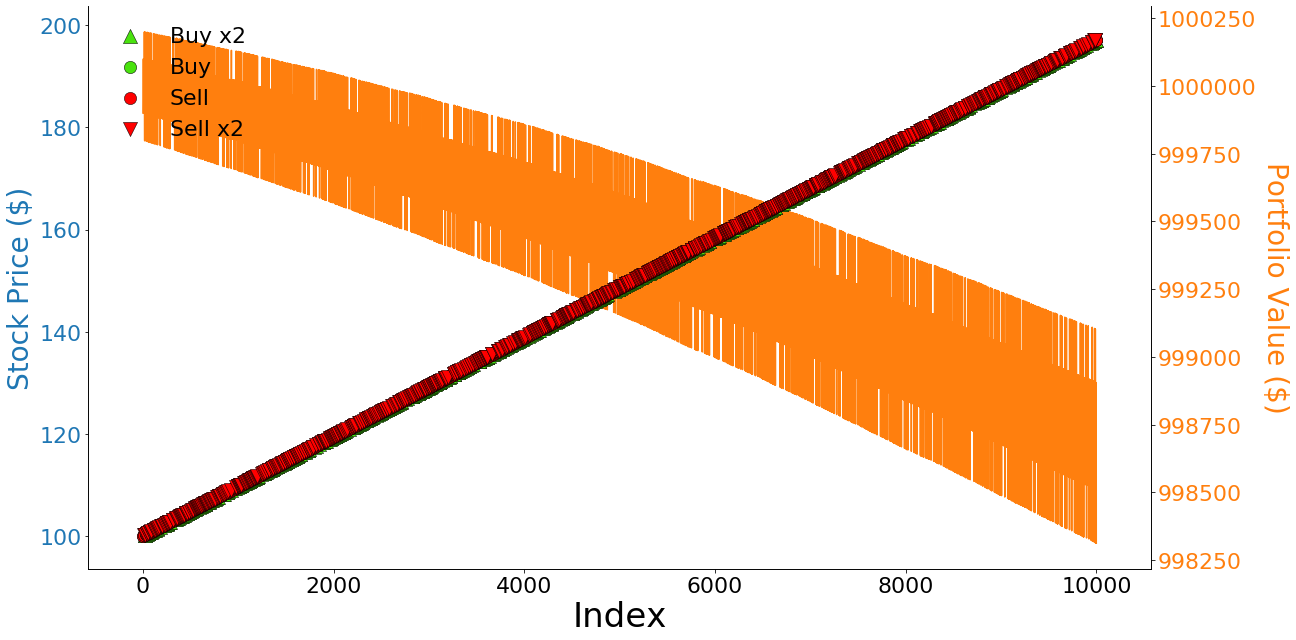

In [100]:
plot(prices, target_actions, portfolio.portfolio[-10000:], right_y_adjust=1.13)


- sometimes, the portfolio values goes to negative :OOOO

In [27]:
import gym
import random
from keras import Sequential
from collections import deque
from keras.layers import Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.activations import relu, linear

import numpy as np
env = Environment(data, INITIAL_BALANCE)
env.seed(0)
np.random.seed(0)


class DQN:

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1.0
        self.gamma = .99
        self.batch_size = 64
        self.epsilon_min = .01
        self.lr = 0.001
        self.epsilon_decay = .996
        self.memory = deque(maxlen=100)
        self.model = self.build_model()

    def build_model(self):

        model = Sequential()
        model.add(Dense(150, input_dim=self.state_space, activation=relu))
        model.add(Dense(120, activation=relu))
        model.add(Dense(self.action_space, activation=linear))
        model.compile(loss='mse', optimizer=Adam(lr=self.lr))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def get_action(self, state):

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        action_values = self.model.predict(state)
        return np.argmax(action_values[0])

    def replay(self):

        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


def train_dqn(episode):

    loss = []
    portfolio_values = []
    agent = DQN(env.action_space.n, env.observation_space.shape[0])
    for e in tqdm(range(episode)):
        state = env.reset()
        state = np.reshape(state, (1, 8))
        score = 0
        max_steps = 300
        for i in range(max_steps):
            action = agent.get_action(state)
            #env.render()
            next_state, reward, done, _ = env.step(action)
            score += reward
            print(reward)
            next_state = np.reshape(next_state, (1, 8))
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()
            if done:
                #print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        loss.append(score)

        # Average score of last 100 episode
        is_solved = np.mean(loss[-100:])
        if is_solved > 200:
            #print('\n Task Completed! \n')
            break
        #print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
    return loss

In [28]:
from tqdm import tqdm
print(env.observation_space)
print(env.action_space)
episodes = 100
loss = train_dqn(episodes)
plt.plot([i+1 for i in range(0, len(loss), 2)], loss[::2])
plt.show()

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Box(0.0, inf, (8,), float32)
Discrete(3)
0.0
0.0
-100.16807539097499
199.95529000286479
0.0
0.0
0.0
-100.21670067042578
100.02617312734947
-100.23615078208968
0.0
-100.25560089375358
100.06499562808312
-100.2750510055339
0.0
0.0
100.10381812881678
0.0
0.0
0.0
0.0
-100.35285145242233
200.32410375983454
-100.37230156420264
0.0
-100.39175167586654
200.40174876130186
0.0
-200.84185368707404
100.22999125614297
0.0
-100.45010201109108
200.51821626350284
0.0
-200.95855435729027
100.28822500724345
100.29793063248508
0.0
0.0
-100.52790245797951
100.33675313321874
-201.09470513940323
100.35616438358556
0.0
0.0
-100.58625279308762
100.39498688431922
-100.60570290486794
200.8287962693721
0.0
-201.2697561449604
100.44351501017809
100.45322063541971
-201.32810648018494
0.0
100.48233751091175
100.49204313603695
-201.40590692707337
0.0
201.0423200232908
-201.4642572622979
201.08114252402447
-201.5031574856257
201.11996502487455
0.0
-201.56150782085024
201.17819877585862
-100.80020402208902
100.6085106

  0%|                                                                                          | 0/100 [00:02<?, ?it/s]


0.0
0.0
-101.47123287676368
101.27819877583534
101.28790440107696
-101.50040804431774
0.0
-101.51985815609805
101.3267269016942
-101.53930826776195
101.34613815217745
0.0
0.0
0.0
-101.58793354709633
101.39466627803631
101.40437190316152
-101.61710871465039
-101.62683377054054
101.43348877876997
101.44319440401159
0.0


KeyboardInterrupt: 